In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [ ]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
# date = "20190830"
run_name = "09_05_2019_run_02"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import raw_signal_utils
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [57]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

FileExistsError: [Errno 17] File exists: '/path/to/data/MinION_sequencing_data_20190905/guppy_3.2.2_09_05_2019_run_02_exec_20190905/sw'

In [ ]:
sw_dir

In [77]:
sw_list = []
for fname in os.listdir(sw_dir):
    if len(re.findall(r"fastq_runid_.*_[\d]+_[\d]+.tsv", fname)) == 0:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [78]:
sw_arr = np.array(sw)

In [79]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

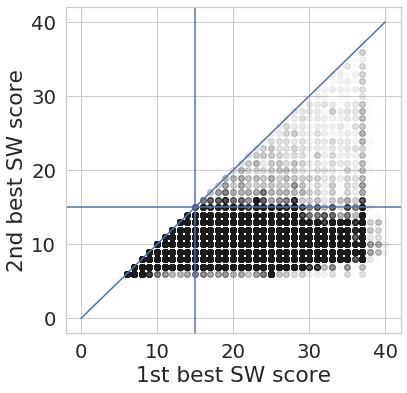

In [80]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

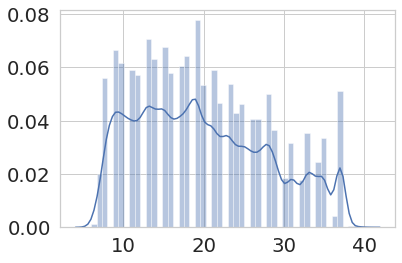

In [81]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [82]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [83]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [84]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [85]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190905/guppy_3.2.2_09_05_2019_run_02_exec_20190905/sw/all_2731f41800830c34961f2695e4ee22f68bd5a5a3.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [86]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.replace(" ", "").split(",")

In [87]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [88]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [89]:
len(accept_molbit)

329977

In [90]:
sum(accept_molbit)

227924

In [91]:
sum(accept_molbit) / len(accept_molbit)

0.6907269294526588

## Extract the best-aligned molbit, across ONLY the extant molbits

In [92]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [93]:
extant_sw = sw.loc[:, extant_sw_cols]

In [94]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [95]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [96]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [97]:
n_extant_is_best

227578

Percentage of well-aligned reads that belong to the true set

In [98]:
n_extant_is_best/len(sw_accepted)

0.9984819501237254

Read counts for each molbit

In [99]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 2082),
 ('1', 1587),
 ('10', 4068),
 ('11', 2957),
 ('16', 16200),
 ('17', 2605),
 ('18', 2044),
 ('19', 14263),
 ('2', 4215),
 ('24', 529),
 ('25', 2128),
 ('26', 6749),
 ('27', 2378),
 ('3', 6541),
 ('32', 3315),
 ('33', 1665),
 ('34', 572),
 ('35', 810),
 ('40', 5488),
 ('41', 4772),
 ('42', 3881),
 ('43', 13974),
 ('52', 600),
 ('53', 1063),
 ('54', 9384),
 ('55', 1757),
 ('60', 7482),
 ('61', 1189),
 ('62', 4213),
 ('63', 8129),
 ('68', 4034),
 ('69', 1340),
 ('70', 1527),
 ('71', 1508),
 ('76', 236),
 ('77', 4077),
 ('78', 522),
 ('79', 637),
 ('8', 2347),
 ('84', 1887),
 ('85', 12542),
 ('86', 5338),
 ('87', 1419),
 ('9', 35291),
 ('92', 5579),
 ('93', 1590),
 ('94', 4495),
 ('95', 6915)]

In [100]:
print("\n".join([str(x) for x in c]))

2082
1587
4068
2957
16200
2605
2044
14263
4215
529
2128
6749
2378
6541
3315
1665
572
810
5488
4772
3881
13974
600
1063
9384
1757
7482
1189
4213
8129
4034
1340
1527
1508
236
4077
522
637
2347
1887
12542
5338
1419
35291
5579
1590
4495
6915


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [101]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [102]:
extant_sw = sw.loc[:, extant_sw_cols]

In [103]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [104]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [105]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [106]:
n_extant_is_best

227578

Percentage of well-aligned reads that belong to the true set

In [107]:
n_extant_is_best/len(sw_accepted)

0.9984819501237254

Read counts for each molbit

In [108]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 2082),
 ('1', 1587),
 ('10', 4068),
 ('11', 2957),
 ('16', 16200),
 ('17', 2605),
 ('18', 2044),
 ('19', 14263),
 ('2', 4215),
 ('24', 529),
 ('25', 2128),
 ('26', 6749),
 ('27', 2378),
 ('3', 6541),
 ('32', 3315),
 ('33', 1665),
 ('34', 572),
 ('35', 810),
 ('40', 5488),
 ('41', 4772),
 ('42', 3881),
 ('43', 13974),
 ('52', 600),
 ('53', 1063),
 ('54', 9384),
 ('55', 1757),
 ('60', 7482),
 ('61', 1189),
 ('62', 4213),
 ('63', 8129),
 ('68', 4034),
 ('69', 1340),
 ('70', 1527),
 ('71', 1508),
 ('76', 236),
 ('77', 4077),
 ('78', 522),
 ('79', 637),
 ('8', 2347),
 ('84', 1887),
 ('85', 12542),
 ('86', 5338),
 ('87', 1419),
 ('9', 35291),
 ('92', 5579),
 ('93', 1590),
 ('94', 4495),
 ('95', 6915)]

In [109]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [110]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [111]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

2082
1587
4207
6540
0
1
1
58
2346
35282
4065
2932
0
20
0
5
16200
2601
2042
14262
1
0
21
0
527
2127
6749
2373
0
6
1
1
3314
1665
572
804
29
6
2
0
5486
4769
3880
13971
0
0
3
14
5
30
2
0
596
1062
9380
1754
7
0
82
0
7481
1189
4193
8129
0
2
2
2
4023
1331
1527
1507
2
0
9
8
219
4068
521
592
0
1
1
0
1887
12525
5337
1405
0
3
0
21
5482
1589
4484
6914


# Plot read counts

In [112]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

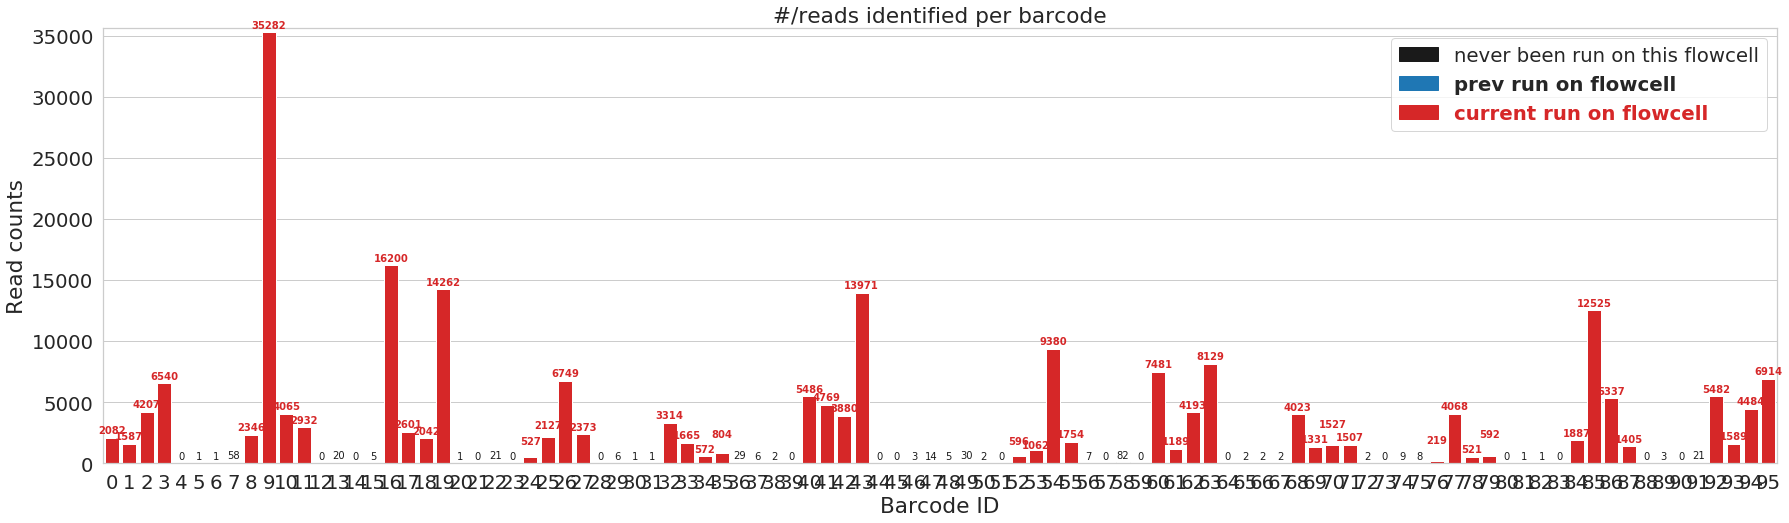

In [118]:
molbits = [str(x) for x in m]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=poss_molbits, vmax=35600)

# Save labels

In [114]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190905/guppy_3.2.2_09_05_2019_run_02_exec_20190905/sw/all_2731f41800830c34961f2695e4ee22f68bd5a5a3.tsv'

In [115]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [116]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20190905/guppy_3.2.2_09_05_2019_run_02_exec_20190905/sw/labels_for_molbits_in_set_2731f41800830c34961f2695e4ee22f68bd5a5a3.tsv


In [117]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
